# Colaborative filtering

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import json
import sys
import os
import gc
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import ast
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ananyaadarsh
Your Kaggle Key: ··········


100%|██████████| 267M/267M [00:04<00:00, 69.0MB/s]


#EDA

In [3]:
PP_recipes = pd.read_csv('/content/food-com-recipes-and-user-interactions/PP_recipes.csv')
PP_users = pd.read_csv('/content/food-com-recipes-and-user-interactions/PP_users.csv')
RAW_interactions = pd.read_csv('/content/food-com-recipes-and-user-interactions/RAW_interactions.csv')
RAW_recipes = pd.read_csv('/content/food-com-recipes-and-user-interactions/RAW_recipes.csv')


In [4]:
display(PP_recipes.head(5))
print()
display(PP_users.head(5))
print()
display(RAW_interactions.head(5))
print()
display(RAW_recipes.head(5))
print()

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [5]:
print('PP_recipes')
print(PP_recipes.info())
print()
print('PP_users')
print(PP_users.info())
print()
print('RAW_interactions')
print(RAW_interactions.info())
print()
print("RAW_recipes")
print(RAW_recipes.info())
print()


PP_recipes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178265 entries, 0 to 178264
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 178265 non-null  int64 
 1   i                  178265 non-null  int64 
 2   name_tokens        178265 non-null  object
 3   ingredient_tokens  178265 non-null  object
 4   steps_tokens       178265 non-null  object
 5   techniques         178265 non-null  object
 6   calorie_level      178265 non-null  int64 
 7   ingredient_ids     178265 non-null  object
dtypes: int64(3), object(5)
memory usage: 10.9+ MB
None

PP_users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25076 entries, 0 to 25075
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   u           25076 non-null  int64 
 1   techniques  25076 non-null  object
 2   items       25076 non-null  object
 3   n_items     25076 no

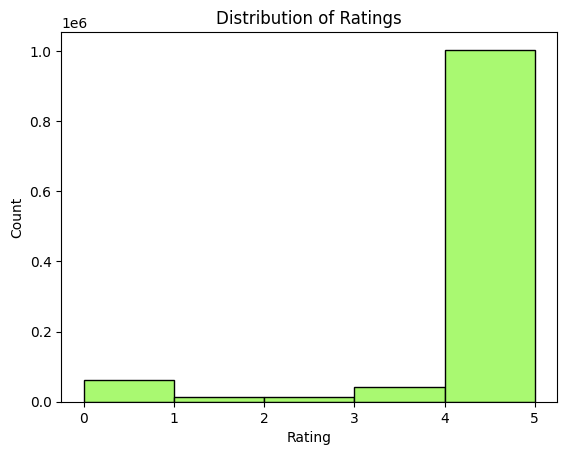

In [6]:
##the plot show the counts of ratings given by user
plt.hist(RAW_interactions['rating'], bins=5, edgecolor='black',color="#a9f971")
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [7]:
#Finding the correalation between time spent of a recipe and number of steps
correl_matrix = RAW_recipes[['minutes', 'n_steps']].corr()
correl_coeff = correl_matrix.loc['minutes', 'n_steps']
print("Correlation coefficient between 'minutes' and 'n_steps':", {correl_coeff})


Correlation coefficient between 'minutes' and 'n_steps': {-0.00025737568163046193}


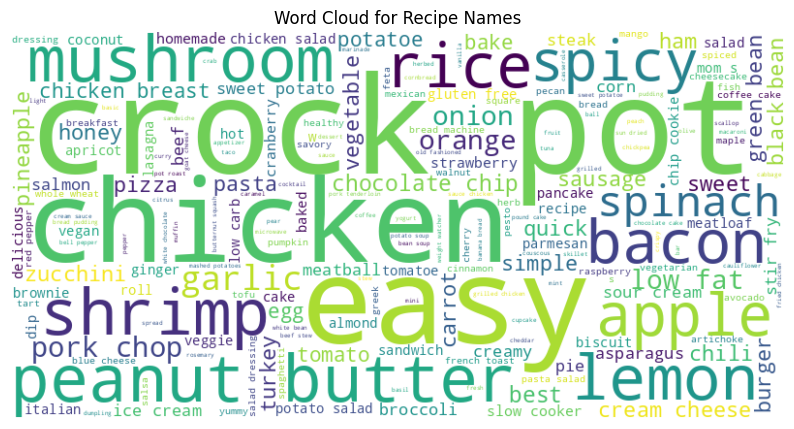

In [8]:
#this wordcloud basically shows the maximum occurence of words
from wordcloud import WordCloud
recipe_names = ' '.join(RAW_recipes['name'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(recipe_names)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Recipe Names')
plt.axis('off')
plt.show()


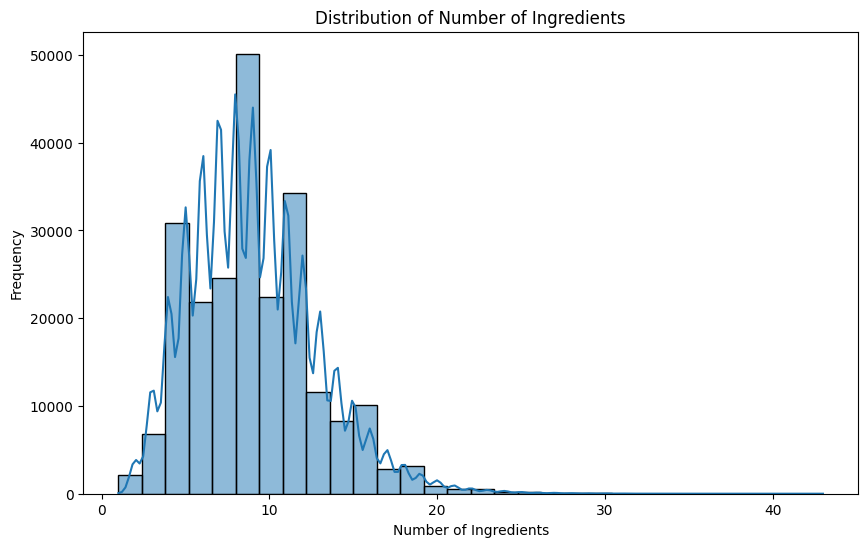

In [9]:
#frequency of number of ingredients
plt.figure(figsize=(10, 6))
sns.histplot(data=RAW_recipes, x='n_ingredients', bins=30, kde=True)
plt.title('Distribution of Number of Ingredients')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()


#Colaborative Filtering system

Class to load and process the data<br>
this Class initializes with paths to recipe and user data, fetches user data, filters users who have rated more than 5 items, explodes items and ratings into separate rows, and considers recipes rated by more than 10 users, splitting the filtered data into training and test sets.

In [10]:
class Data:
  # constructor ti initialize variable
  def __init__(self):
    self.recipes_data_path="/content/food-com-recipes-and-user-interactions/PP_recipes.csv"
    self.user_data_path="/content/food-com-recipes-and-user-interactions/PP_users.csv"
    self.user_data=None
    self.filtered_user_data=None
    self.test_data=None

  def initialise_user_data(self):
    print("Fetching User Data")
    self.user_data=pd.read_csv(self.user_data_path)
    print("User Data Fetched")
    print("self.user_data.shape:",self.user_data.shape)
    print("COlumns:",self.user_data.columns)

  def get_user_data(self):
    return self.user_data
  #Method to filter out Candidate Data
  def filter_user_data(self):
    filtered_data=self.user_data[self.user_data["n_ratings"]>5][["u","items","ratings"]]
    print("Considering users who have rated more then 5 items only : \n Updated shape :",filtered_data.shape)

    # Exploding Items and Rating list in seprate rows
    filtered_data['items'] = filtered_data['items'].apply(ast.literal_eval)
    filtered_data['ratings'] = filtered_data['ratings'].apply(ast.literal_eval)
    new_rows = []
    for idx, row in filtered_data.iterrows():
      user = row['u']
      items = row['items']
      ratings = row['ratings']
      for i in range(len(items)):
          new_rows.append({'user': user, 'item': items[i], 'rating': ratings[i]})

    self.filtered_user_data = pd.DataFrame(new_rows)

    print("Exploding Items and Rating list in seprate rows ,filtered_user_data.shape :  ",self.filtered_user_data.shape)

    # Considering receipes which are rated by more than 10 users
    recipes_id =self.filtered_user_data.groupby("item").count()
    recipes_id=recipes_id[recipes_id["user"]>10]
    recipes_id

    self.filtered_user_data=self.filtered_user_data[self.filtered_user_data["item"].isin(recipes_id.index)]

    print("Considering receipes which are rated by more than 10 users. Updated filtered_user_data.shape :  ",self.filtered_user_data.shape)
    # Spliting the data in train and test
    self.filtered_user_data, self.test_data = train_test_split(self.filtered_user_data, test_size=0.2, random_state=42)


Class to implement user-Based and Item-Based colaborative System

In [11]:
class collaborative_filtering:
  def __init__(self):
    A=None

  #with the help of this funtion we have created a user_item matrix using pivot funtion
  def create_user_item(self,final_user_recipe_data):
    return final_user_recipe_data.pivot_table(index="user",columns=["item"],values="rating")

  #the funtion is use to normalized the user-item matrix with the help of "MEAN-CENTERING"
  def normalize_user_item_mean_centering(self,row):
    return (row-row.mean())/(row.max()-row.min())

  #the funtion is use to normalized the user-item matrix with the help of "Z-Score"
  def normalize_user_item_z_score(self,row):
    return (row-row.mean())/row.std()

  #the funtion will provide us with similarity_matrix for item_item using inbuit cosine_similarity funtion
  def get_item_item_sim(self,norm_user_item):
    item_similarity=cosine_similarity(norm_user_item.T)
    return pd.DataFrame(item_similarity,index=norm_user_item.columns,columns=norm_user_item.columns)

  #same we did for user-user
  def get_user_user_sim(self,norm_user_item):
    user_user_similarity=cosine_similarity(norm_user_item)
    return pd.DataFrame(user_user_similarity,index=norm_user_item.index,columns=norm_user_item.index)
#calculating similar items for a given user
  def get_similar_score (self,recipes_id,rating,item_item_similarity):
    similar_score = item_item_similarity[recipes_id]*(rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    return  similar_score

#retrieving similar items for a given user
  def get_similar_items(self,user_id,item_item_similarity,final_user_recipe_data):
    user=final_user_recipe_data[final_user_recipe_data["user"]==user_id]
    similar_items=pd.DataFrame()
    for indx,row in user.iterrows():
      similar_items=similar_items.append(self.get_similar_score(row["item"],row["rating"],item_item_similarity),ignore_index=True)

    similar_items=similar_items.sum().sort_values(ascending=False)

    similar_items=pd.DataFrame(similar_items[~similar_items.index.isin(user["item"])])

    if len(similar_items[similar_items[0]>0])>10:
      similar_items=similar_items[similar_items[0]>0].head(10)
    else:
      similar_items=similar_items.head(10)
    return similar_items
 #calculates the similarity scores of users with the specified user ID, sorts them in descending order, and returns the scores.

  def get_similar_users_score (self,user_id,user_user_similarity):
    similar_score=user_user_similarity[user_id]
    similar_score= similar_score.sort_values(ascending=False)
    return  similar_score

  #retrieves the top similar users based on their similarity scores, excluding the user itself, and returns them as a DataFrame containing the user IDs and their similarity scores.

  def get_similar_users(self,user_user_similarity):
    similar_users=pd.DataFrame(self.get_similar_users_score(0,user_user_similarity))
    similar_users=similar_users[similar_users.index!=0]
    similar_users=similar_users[similar_users[0]>0].head(5)
    return similar_users

    final_user_recipe_data[final_user_recipe_data["user"].isin(similar_users.index)]

#predict rating using item-item collaborative filtering
# It considers the ratings of similar items that the user has interacted with, weighted by their similarity scores, and normalizes the prediction within the range of 0 to 5.

  def predict_rating_item_item(self,data,user,item,item_item_similarity):
    user_data=data.filtered_user_data[data.filtered_user_data["user"]==user]
    user_data.index=user_data["item"]

    df=pd.DataFrame(item_item_similarity.loc[item]).sort_values(by=item,ascending=False)
    df=df.loc[user_data["item"]].sort_values(by=item,ascending=False).head(5)
    df["rating"]=user_data["rating"]
    pred= ((df["rating"]*df[item]).sum())/(df[item].sum())
    if pred > 5 :
      return 5
    elif pred<0:
      return 0
    else:
      return pred
#predict rating using user-user collaborative filtering
##by considering the ratings of similar users for that item, weighted by their similarity scores, and normalizing the prediction within the range of 0 to 5.

  def predict_rating_user_based(self,data,user,item,user_user_similarity):
    user_data=data.filtered_user_data[data.filtered_user_data["item"]==item]
    user_data.index=user_data["user"]
    df=pd.DataFrame(user_user_similarity.loc[user]).sort_values(by=user,ascending=False)
    df=df.loc[user_data.index].sort_values(by=user,ascending=False).head(5)
    df["rating"]=user_data["rating"]
    pred= ((df["rating"]*df[user]).sum())/(df[user].sum())
    if pred > 5 :
      return 5
    elif pred<0:
      return 0
    else:
      return pred


Reading the Csv file , and preprocessing the data as per out requirement

In [12]:
data=Data()
cf=collaborative_filtering()

In [13]:

data.initialise_user_data()
data.filter_user_data()

Fetching User Data
User Data Fetched
self.user_data.shape: (25076, 6)
COlumns: Index(['u', 'techniques', 'items', 'n_items', 'ratings', 'n_ratings'], dtype='object')
Considering users who have rated more then 5 items only : 
 Updated shape : (13412, 3)
Exploding Items and Rating list in seprate rows ,filtered_user_data.shape :   (662846, 3)
Considering receipes which are rated by more than 10 users. Updated filtered_user_data.shape :   (286077, 3)


Original User_data

In [14]:
data.user_data

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376
...,...,...,...,...,...,...
25071,25071,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[144172, 154054]",2,"[5.0, 5.0]",2
25072,25072,"[1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[162436, 148228]",2,"[5.0, 5.0]",2
25073,25073,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[162681, 172034]",2,"[5.0, 5.0]",2
25074,25074,"[2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[157808, 159896]",2,"[5.0, 5.0]",2


Data We have transformed to and also split in train and test

In [15]:
data.filtered_user_data

,user,item,rating
564823,8223,5004,5.0
212843,575,201,5.0
68472,171,161890,5.0
287368,1106,131023,5.0
49906,130,53915,5.0
...,...,...,...
357253,1854,171087,4.0
618992,13002,9771,5.0
382396,2224,36782,5.0
412807,2751,82187,5.0


Test Data


In [16]:
data.test_data

,user,item,rating
201373,541,98854,4.0
547637,7231,101225,5.0
136621,321,107224,5.0
591926,10249,73325,5.0
487412,4657,31260,5.0
...,...,...,...
449349,3559,58338,5.0
268526,926,119408,5.0
424694,2948,74633,5.0
509360,5396,92805,5.0


In [17]:
top_users = data.filtered_user_data.groupby('user')['rating'].count().nlargest(10).reset_index()
top_items = data.filtered_user_data.groupby('item')['rating'].count().nlargest(10).reset_index()

print("Top 10 users with the highest number of ratings:")
print(top_users)
print()
print("Top 10 items with the highest number of ratings:")
print(top_items)

Top 10 users with the highest number of ratings:
   user  rating
0   453    1123
1   275     765
2    82     693
3   193     679
4     3     614
5   164     586
6   546     563
7   130     549
8   208     546
9   267     514

Top 10 items with the highest number of ratings:
     item  rating
0   99787     743
1  134610     690
2  135961     589
3  117899     572
4  147374     532
5  101819     525
6   37047     470
7  127080     462
8   56425     461
9   52334     447


user-item matrix

In [18]:
#this basically takes the filtered data and makes pivot table using "user" as rows and "item" as columns
user_item = cf.create_user_item(data.filtered_user_data)
user_item

item,7,66,109,112,120,125,145,153,156,159,...,178044,178051,178073,178084,178090,178094,178102,178103,178132,178244
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Replacing Nan values with 0

In [19]:
#filling the NaN values with 0
user_item=user_item.fillna(0)
user_item

item,7,66,109,112,120,125,145,153,156,159,...,178044,178051,178073,178084,178090,178094,178102,178103,178132,178244
user,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Mean Centering

Normalizying user-item matrix using Mean Centering

In [20]:
#Here we normalized the matrix using mean_centering funtions we have define above
mc_norm_user_item=user_item.apply(cf.normalize_user_item_mean_centering)
mc_norm_user_item

item,7,66,109,112,120,125,145,153,156,159,...,178044,178051,178073,178084,178090,178094,178102,178103,178132,178244
user,,,,,,,,,,,,,,,,,,,,,
0,-0.000696,-0.001664,-0.001029,-0.00171,-0.001226,-0.000741,-0.000908,-0.000893,-0.002678,-0.000787,...,-0.001574,-0.000605,-0.000726,-0.000514,-0.000968,-0.001453,-0.000666,-0.000726,-0.001271,-0.000953
1,-0.000696,-0.001664,-0.001029,-0.00171,-0.001226,-0.000741,-0.000908,-0.000893,-0.002678,-0.000787,...,-0.001574,-0.000605,-0.000726,-0.000514,-0.000968,-0.001453,-0.000666,-0.000726,-0.001271,-0.000953
2,-0.000696,-0.001664,-0.001029,-0.00171,-0.001226,-0.000741,-0.000908,-0.000893,-0.002678,-0.000787,...,-0.001574,-0.000605,-0.000726,-0.000514,-0.000968,-0.001453,-0.000666,-0.000726,-0.001271,-0.000953
3,-0.000696,-0.001664,-0.001029,-0.00171,-0.001226,-0.000741,-0.000908,-0.000893,-0.002678,-0.000787,...,-0.001574,-0.000605,-0.000726,-0.000514,-0.000968,-0.001453,-0.000666,-0.000726,-0.001271,-0.000953
4,-0.000696,-0.001664,-0.001029,-0.00171,-0.001226,-0.000741,-0.000908,-0.000893,-0.002678,-0.000787,...,-0.001574,-0.000605,-0.000726,-0.000514,-0.000968,-0.001453,-0.000666,-0.000726,-0.001271,-0.000953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,-0.000696,-0.001664,-0.001029,-0.00171,-0.001226,-0.000741,-0.000908,-0.000893,-0.002678,-0.000787,...,-0.001574,-0.000605,-0.000726,-0.000514,-0.000968,-0.001453,-0.000666,-0.000726,-0.001271,-0.000953
24769,-0.000696,-0.001664,-0.001029,-0.00171,-0.001226,-0.000741,-0.000908,-0.000893,-0.002678,-0.000787,...,-0.001574,-0.000605,-0.000726,-0.000514,-0.000968,-0.001453,-0.000666,-0.000726,-0.001271,-0.000953
24792,-0.000696,-0.001664,-0.001029,-0.00171,-0.001226,-0.000741,-0.000908,-0.000893,-0.002678,-0.000787,...,-0.001574,-0.000605,-0.000726,-0.000514,-0.000968,-0.001453,-0.000666,-0.000726,-0.001271,-0.000953


##Item-Based

Item-item collaborative filtering is a type of recommendation system that is based on the similarity between items calculated using the rating users have given to items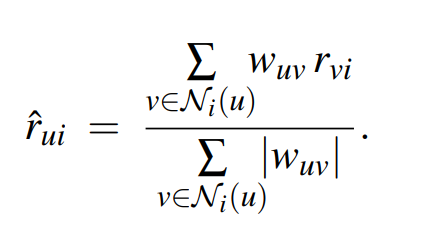

It takes in the normalized user_item matrix and computeds the cosine similarity between the items, resulting in a matrix where each cell represents the similarity score between two items.

In [21]:
item_item_similarity=cf.get_item_item_sim(mc_norm_user_item)
item_item_similarity

item,7,66,109,112,120,125,145,153,156,159,...,178044,178051,178073,178084,178090,178094,178102,178103,178132,178244
item,,,,,,,,,,,,,,,,,,,,,
7,1.000000,-0.001112,-0.000882,-0.001135,-0.001019,-0.000748,-0.000821,-0.000843,-0.001446,-0.000779,...,-0.001094,-0.000699,-0.000747,-0.000625,-0.000853,-0.001070,-0.000734,-0.000747,-0.000998,-0.000852
66,-0.001112,1.000000,-0.001322,-0.001702,-0.001528,-0.001121,-0.001231,-0.001264,0.034629,-0.001168,...,-0.001640,-0.001048,-0.001120,-0.000937,-0.001279,-0.001605,-0.001100,-0.001120,-0.001496,-0.001278
109,-0.000882,-0.001322,1.000000,-0.001350,-0.001212,0.087307,0.078079,-0.001003,-0.001719,-0.000927,...,-0.001301,-0.000831,-0.000888,-0.000743,-0.001014,0.063153,-0.000872,-0.000888,-0.001187,0.077138
112,-0.001135,-0.001702,-0.001350,1.000000,-0.001560,-0.001145,-0.001256,-0.001290,0.034354,-0.001193,...,-0.001674,-0.001069,-0.001143,-0.000957,-0.001306,-0.001638,-0.001123,-0.001143,-0.001528,0.059234
120,-0.001019,-0.001528,-0.001212,-0.001560,1.000000,-0.001028,-0.001128,-0.001159,0.034650,-0.001071,...,0.116414,-0.000960,-0.001026,-0.000859,-0.001172,-0.001471,-0.001008,-0.001026,-0.001371,-0.001171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178094,-0.001070,-0.001605,0.063153,-0.001638,-0.001471,-0.001080,-0.001185,-0.001217,-0.002087,-0.001125,...,0.050676,-0.001008,0.076213,-0.000902,-0.001231,1.000000,-0.001059,-0.001078,-0.001440,-0.001230
178102,-0.000734,-0.001100,-0.000872,-0.001123,-0.001008,-0.000740,-0.000812,-0.000834,-0.001430,-0.000771,...,-0.001082,-0.000691,-0.000739,-0.000618,-0.000844,-0.001059,1.000000,-0.000739,-0.000987,-0.000843
178103,-0.000747,-0.001120,-0.000888,-0.001143,-0.001026,-0.000753,0.094014,-0.000849,0.055175,-0.000785,...,0.057225,-0.000704,-0.000752,-0.000630,-0.000859,-0.001078,-0.000739,1.000000,-0.001005,-0.000858


This is used to retrieves a list of items similar to the ones interacted with by a given user, based on the item-item similarity matrix and the filtered user data.

It takes user_id,it selects the interactions of the specified user from the filtered user data. For each item interacted with by the user, it calculates a score for similar items based on their similarity to the interacted item and the rating given by the user,sums up the scores for all similar items and sorts them in descending order. Returns the top 10 similar items as a DataFrame.

In [22]:
similar_items = cf.get_similar_items(0,item_item_similarity,data.filtered_user_data)
similar_items

<ipython-input-11-201ab1aeda0d>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_items=similar_items.append(self.get_similar_score(row["item"],row["rating"],item_item_similarity),ignore_index=True)


,0
item,
161107,1.445301
72408,1.263189
121169,1.068103
74013,1.045752
59116,1.013768
108099,1.003857
104787,0.974512
163619,0.957735
68560,0.955450


In [23]:
similar_items

,0
item,
161107,1.445301
72408,1.263189
121169,1.068103
74013,1.045752
59116,1.013768
108099,1.003857
104787,0.974512
163619,0.957735
68560,0.955450


Rating Prediction for item_item Based

This approach focuses on finding similarities between items. It predicts the rating of an item for a user by considering the ratings of similar items that the user has interacted with.

We calculate the predicted rating using the predict_rating_item_item() methed. This method estimates the rating for a user-item pair based on the ratings of similar items that the user has interacted with. The predicted rating is calculated by considering the similarity between items and the ratings given by the user to those similar items.

We store the predictions, along with actual ratings and user-item information, in a list of dictionaries (predicted_rating). Each dictionary contains details such as user ID, item ID, actual rating, and predicted rating for each user-item pair in the test dataset.

In [24]:
predicted_rating=[]
for indx,row in data.test_data[data.test_data["user"].isin(data.filtered_user_data["user"])].iterrows():
  pred=cf.predict_rating_item_item(data,int(row["user"]),int(row["item"]),item_item_similarity)
  pred_dict={"user":row["user"],"item":row["item"],"rating":row["rating"],"predicted":pred}
  predicted_rating.append(pred_dict)

predicted_rating=pd.DataFrame(predicted_rating)
predicted_rating

<ipython-input-11-201ab1aeda0d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rating"]=user_data["rating"]
<ipython-input-11-201ab1aeda0d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rating"]=user_data["rating"]
<ipython-input-11-201ab1aeda0d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

,user,item,rating,predicted
0,541.0,98854.0,4.0,4.000258
1,7231.0,101225.0,5.0,3.743301
2,321.0,107224.0,5.0,5.000000
3,10249.0,73325.0,5.0,4.564174
4,4657.0,31260.0,5.0,5.000000
...,...,...,...,...
57116,3559.0,58338.0,5.0,3.167209
57117,926.0,119408.0,5.0,4.625075
57118,2948.0,74633.0,5.0,4.166199
57119,5396.0,92805.0,5.0,3.791742


Evaluation<BR>
Here we basically just subtracted actual rating to predicted rating and took mean value so as to get our Mean Absolute error

In [25]:
MAE=abs(predicted_rating["rating"]-predicted_rating["predicted"]).mean()
print("MAE : ",MAE)

MAE :  0.5185483536709306


##User-Based

finding similarities/distance between users

Calculates the cosine similarity between the users of the normalized user-item
matrix.
Matrix represents the similarity between users, where each cell contains a similarity score indicating how similar two users are in their preferences or ratings for items.




In [26]:
user_user_similarity=cf.get_user_user_sim(mc_norm_user_item)
user_user_similarity

user,0,1,2,3,4,5,7,8,9,10,...,24524,24571,24584,24617,24730,24745,24769,24792,24826,24848
user,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.001689,0.005403,-0.017447,-0.013751,-0.008924,0.016244,-0.015711,0.017549,-0.016991,...,0.011936,0.012823,0.004767,0.006887,0.016791,0.007485,0.002610,0.018218,0.002849,0.008697
1,0.001689,1.000000,0.002140,-0.023815,0.018469,-0.007869,0.008103,-0.013114,0.009164,-0.013938,...,0.006042,0.006757,0.001303,0.003006,0.008548,0.003366,-0.000551,0.009708,0.000162,0.004200
2,0.005403,0.002140,1.000000,-0.035449,-0.016483,-0.010667,0.019887,-0.018835,0.021454,-0.020389,...,0.014606,0.015671,0.005917,0.008464,0.020544,0.009192,0.003336,0.022257,0.003584,0.010658
3,-0.017447,-0.023815,-0.035449,1.000000,0.041864,0.007549,-0.078940,0.036583,-0.078493,0.040532,...,-0.056547,-0.056343,-0.020087,-0.019781,-0.038203,-0.042454,-0.021404,-0.078264,0.000505,-0.044540
4,-0.013751,0.018469,-0.016483,0.041864,1.000000,0.037972,-0.035737,0.029978,-0.035214,0.011015,...,0.046822,-0.025225,-0.019371,-0.018700,-0.035517,-0.019507,-0.021064,-0.034945,-0.016685,-0.020272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,0.007485,0.003366,0.009192,-0.042454,-0.019507,-0.012407,0.026564,-0.022317,0.028435,-0.024292,...,0.019462,0.020738,0.008482,0.011537,0.027349,1.000000,0.005454,0.029394,0.005465,0.014310
24769,0.002610,-0.000551,0.003336,-0.021404,-0.021064,-0.014484,0.013487,-0.023968,0.015420,-0.025416,...,0.010092,0.011394,0.001733,0.004830,0.014298,0.005454,1.000000,0.016411,-0.000242,0.006935
24792,0.018218,0.009708,0.022257,-0.078264,-0.034945,-0.021272,0.060941,-0.040095,0.064370,-0.044235,...,0.044464,0.046816,0.021721,0.027371,0.062380,0.029394,0.016411,1.000000,0.015190,0.033119


finding simmilar user profiles for a specified user

It computes and retrieves similar users for a given user based on their preferences or rating patterns. It utilizes a user-user similarity matrix to quantify the similarity between users and then identifies the top similar users.

In [27]:
similar_user=cf.get_similar_users(user_user_similarity)
similar_user

,0
user,
10634,0.263897
7511,0.263039
21127,0.215868
19019,0.215193
19032,0.195379


fetching all the items which are consumed by the similar user

In [28]:
data.filtered_user_data[data.filtered_user_data["user"].isin(similar_user.index)]

,user,item,rating
652852,19032,27749,5.0
596380,10634,12083,4.0
658581,21127,177124,5.0
652779,19019,153988,5.0
652846,19032,68033,5.0
652783,19019,52334,0.0
596378,10634,89385,4.0
658579,21127,90038,5.0
553405,7511,55924,5.0
652851,19032,113963,5.0


Rating prediction

In [29]:
cf.predict_rating_user_based(data,541,98854,user_user_similarity)

4.352977197429211

"In the user-user based rating prediction approach, we focus on finding similarities between users. We predict the rating of an item for a user by considering the ratings given to similar items by other users who are similar to the target user.

We calculate the predicted rating using the predict_rating_user_based() method. This method estimates the rating for a user-item pair based on the ratings of similar users who have interacted with the item.

The predicted rating is then calculated by considering the similarity between users and the ratings given by those similar users to the same item.

We store the predictions, along with actual ratings and user-item information, in a list of dictionaries (predicted_rating). Each dictionary contains details such as user ID, item ID, actual rating, and predicted rating for each user-item pair in the test dataset."

In [ ]:
predicted_rating=[]
for indx,row in data.test_data[data.test_data["user"].isin(data.filtered_user_data["user"])].iterrows():
  pred=cf.predict_rating_user_based(data,int(row["user"]),int(row["item"]),user_user_similarity)
  pred_dict={"user":row["user"],"item":row["item"],"rating":row["rating"],"predicted":pred}
  predicted_rating.append(pred_dict)
predicted_rating=pd.DataFrame(predicted_rating)
predicted_rating

In [ ]:
MAE=abs(predicted_rating["rating"]-predicted_rating["predicted"]).mean()
print("MAE : ",MAE)

#Z-Score

Logic for the below code is same we just user Z_score to normalize instead of Mean_centeraing

Normalizying user-item matrix using ZScore

In [ ]:
mc_norm_user_item=user_item.apply(cf.normalize_user_item_z_score)
mc_norm_user_item

finding similarities/distance between items

In [ ]:
item_item_similarity=cf.get_item_item_sim(mc_norm_user_item)
item_item_similarity

In [ ]:
similar_items = cf.get_similar_items(0,item_item_similarity,data.filtered_user_data)
similar_items

Rating Prediction

In [ ]:
cf.predict_rating_item_item(data,541,98854,item_item_similarity)

In [ ]:
predicted_rating=[]
for indx,row in data.test_data[data.test_data["user"].isin(data.filtered_user_data["user"])].iterrows():
  pred=cf.predict_rating_item_item(data,int(row["user"]),int(row["item"]),item_item_similarity)
  pred_dict={"user":row["user"],"item":row["item"],"rating":row["rating"],"predicted":pred}
  predicted_rating.append(pred_dict)

predicted_rating=pd.DataFrame(predicted_rating)
predicted_rating

,user,item,rating,predicted
0,541.0,98854.0,4.0,4.000258
1,7231.0,101225.0,5.0,3.743301
2,321.0,107224.0,5.0,5.000000
3,10249.0,73325.0,5.0,4.564174
4,4657.0,31260.0,5.0,5.000000
...,...,...,...,...
57116,3559.0,58338.0,5.0,3.167209
57117,926.0,119408.0,5.0,4.625075
57118,2948.0,74633.0,5.0,4.166199
57119,5396.0,92805.0,5.0,3.791742


In [ ]:
MAE=abs(predicted_rating["rating"]-predicted_rating["predicted"]).mean()
print("MAE : ",MAE)

MAE :  0.5185323190758648


finding similar items for a specific user

finding similarities/distance between users

In [ ]:

user_user_similarity=cf.get_user_user_sim(mc_norm_user_item)
user_user_similarity

user,0,1,2,3,4,5,7,8,9,10,...,24524,24571,24584,24617,24730,24745,24769,24792,24826,24848
user,,,,,,,,,,,,,,,,,,,,,
0,1.000000,-6.589687e-04,0.000597,0.002573,-0.005053,-0.003562,0.007760,-0.004613,0.005242,-0.007182,...,0.002494,0.001886,0.001612,0.001026,0.006760,0.001198,0.001093,0.003175,0.000874,1.266846e-03
1,-0.000659,1.000000e+00,-0.000377,-0.011486,0.016130,-0.003514,0.002633,-0.004381,0.001775,-0.006598,...,0.000635,0.000474,-0.000252,-0.000050,0.002281,-0.000049,-0.000021,0.001083,-0.000622,-4.115092e-07
2,0.000597,-3.774109e-04,1.000000,-0.015818,-0.006179,-0.004250,0.012684,-0.005618,0.008572,-0.008900,...,0.004220,0.003196,0.003180,0.001948,0.011059,0.002268,0.002055,0.005186,0.002056,2.364521e-03
3,0.002573,-1.148598e-02,-0.015818,1.000000,0.015911,-0.001837,-0.074539,0.017253,-0.050431,0.025259,...,-0.027618,-0.020999,-0.021912,0.016822,-0.043378,-0.019415,0.010667,-0.030397,0.001647,-1.964881e-02
4,-0.005053,1.613035e-02,-0.006179,0.015911,1.000000,0.018373,-0.027870,0.001846,-0.018858,0.001578,...,0.014046,-0.007927,-0.011348,-0.006454,-0.024370,-0.007467,-0.006654,-0.011362,-0.009529,-7.542981e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,0.001198,-4.872044e-05,0.002268,-0.019415,-0.007467,-0.005034,0.018365,-0.006768,0.012413,-0.010867,...,0.006212,0.004708,0.004992,0.003015,0.016019,1.000000,0.003166,0.007506,0.003423,3.632628e-03
24769,0.001093,-2.099896e-05,0.002055,0.010667,-0.006654,-0.004481,0.016533,-0.006030,0.011175,-0.009690,...,0.005597,0.004242,0.004512,0.002723,0.014421,0.003166,1.000000,0.006757,0.003102,3.279869e-03
24792,0.003175,1.083406e-03,0.005186,-0.030397,-0.011362,-0.007373,0.036579,-0.010237,0.024730,-0.016853,...,0.012617,0.009568,0.010864,0.006463,0.031921,0.007506,0.006757,1.000000,0.007876,7.730972e-03


finding simmilar user profiles for a specified user

In [ ]:
similar_user=cf.get_similar_users(user_user_similarity)
similar_user

,0
user,
13174,0.266091
7057,0.264999
3826,0.228333
18020,0.221310
7228,0.214980


fetching all the items which are consumed by the similar user

In [ ]:
data.filtered_user_data[data.filtered_user_data["user"].isin(similar_user.index)]

,user,item,rating
544210,7057,125064,5.0
547554,7228,91850,4.0
547551,7228,76205,5.0
648972,18020,93815,5.0
547559,7228,142634,5.0
461610,3826,1646,5.0
544206,7057,173660,4.0
648974,18020,152272,5.0
544209,7057,68456,4.0
544214,7057,34789,4.0


Rating Prediction

In [ ]:
cf.predict_rating_user_based(data,541,98854,user_user_similarity)

4.032599505708888

In [ ]:
predicted_rating=[]
for indx,row in data.test_data[data.test_data["user"].isin(data.filtered_user_data["user"])].iterrows():
  pred=cf.predict_rating_user_based(data,int(row["user"]),int(row["item"]),user_user_similarity)
  pred_dict={"user":row["user"],"item":row["item"],"rating":row["rating"],"predicted":pred}
  predicted_rating.append(pred_dict)
predicted_rating=pd.DataFrame(predicted_rating)
predicted_rating

,user,item,rating,predicted
0,541.0,98854.0,4.0,4.032600
1,7231.0,101225.0,5.0,4.995943
2,321.0,107224.0,5.0,5.000000
3,10249.0,73325.0,5.0,4.707987
4,4657.0,31260.0,5.0,2.886999
...,...,...,...,...
57116,3559.0,58338.0,5.0,5.000000
57117,926.0,119408.0,5.0,5.000000
57118,2948.0,74633.0,5.0,5.000000
57119,5396.0,92805.0,5.0,5.000000


In [ ]:
MAE=abs(predicted_rating["rating"]-predicted_rating["predicted"]).mean()
print("MAE : ",MAE)

MAE :  0.5954065146898986


#Using Matrix Factorization (SVD)

Matrix factorization is a method used in collaborative filtering to uncover latent features that explain observed ratings. It decomposes the user-item ratings matrix into latent factors, capturing underlying patterns in the data. Examples include SVD-based models, which have gained popularity due to their accuracy and scalability. Matrix factorization aims to model observed ratings directly, avoiding issues with missing data and overfitting. It forms the basis for various recommendation techniques, such as SVD, which integrate user feedback to improve prediction accuracy.

The rating
is predicted by also adding  baseline predictors that depend only
on the user or item. Thus, a rating is predicted by the rule $\hat{r}_{ui} = \mu + b_i + b_u + q_i^\top p_u$
<br>b<sub>i</sub> = average rating of item i - μ
<br>b<sub>u</sub> = average rating by user u - μ

In [30]:
class Matrix_Factorization:
  def __init__(self):
    self.U=None
    self.Vt=None
    self.bi=None
    self.bu=None
    self.U_Vt=None
    self.avg_rating=None
  # Method  to Calculate SVD
  def calc_svd(self,user_item):
    K = 2 # Number of latent features
    svd = TruncatedSVD(n_components=K)
    self.U = svd.fit_transform(user_item)
    self.Vt=svd.components_
    self.U_Vt = pd.DataFrame(np.dot(self.U,self.Vt), index=user_item.index, columns=user_item.columns)
    return self.U_Vt
  # Method to calculate average
  def calc_avg(self,data):
    self.avg_rating = data.filtered_user_data['rating'].mean()
    return self.avg_rating

  # Method to calculate item bias
  def calc_item_bias(self,data):
    item_counts = data.filtered_user_data['item'].value_counts()
    item_ratings =data.filtered_user_data.groupby('item')['rating'].sum()
    self.bi = (item_ratings / item_counts - self.avg_rating).fillna(0)
    return self.bi
  # Method to Calculate user bias
  def calc_user_bias(self,data):
    # Compute user biases
    user_counts = data.filtered_user_data['user'].value_counts()
    user_ratings = data.filtered_user_data.groupby('user')['rating'].sum()
    self.bu = (user_ratings / user_counts - self.avg_rating).fillna(0)
    return self.bu

  #Method to predict ratings
  def predict(self,user,item):
    return self.avg_rating + self.bi[item] + self.bu[user] + self.U_Vt.loc[user][item]











In [31]:
mf=Matrix_Factorization()


In [32]:
mf.calc_avg(data)

4.620713009206462

Calculating truncated SVD

In [33]:
mf.calc_svd(mc_norm_user_item)

item,7,66,109,112,120,125,145,153,156,159,...,178044,178051,178073,178084,178090,178094,178102,178103,178132,178244
user,,,,,,,,,,,,,,,,,,,,,
0,-0.000330,-0.002130,-0.000857,-0.001216,-0.000489,-0.000297,-0.000834,-0.000469,-0.002578,-0.000346,...,-0.001097,-0.000183,-0.000761,-0.000620,-0.000851,-0.000966,-0.000380,-0.000534,-0.000906,-0.000656
1,-0.000317,-0.002043,0.000130,-0.001042,-0.000330,-0.000113,-0.000118,-0.000371,-0.002459,-0.000071,...,-0.000988,-0.000170,-0.000713,-0.000556,-0.000771,-0.000927,-0.000334,-0.000413,-0.000873,-0.000142
2,-0.000304,-0.001959,-0.001526,-0.001215,-0.000558,-0.000407,-0.001295,-0.000492,-0.002382,-0.000520,...,-0.001058,-0.000172,-0.000714,-0.000601,-0.000818,-0.000889,-0.000373,-0.000568,-0.000830,-0.000981
3,0.015326,0.098825,0.033837,0.055645,0.021833,0.012724,0.034444,0.021263,0.119526,0.014426,...,0.050489,0.008460,0.035204,0.028551,0.039202,0.044843,0.017449,0.024145,0.042056,0.027425
4,0.002123,0.013686,0.004208,0.007644,0.002954,0.001675,0.004427,0.002905,0.016546,0.001867,...,0.006960,0.001169,0.004867,0.003934,0.005406,0.006210,0.002401,0.003294,0.005826,0.003553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,-0.000353,-0.002279,-0.000998,-0.001312,-0.000535,-0.000333,-0.000950,-0.000508,-0.002759,-0.000392,...,-0.001179,-0.000196,-0.000816,-0.000667,-0.000914,-0.001034,-0.000409,-0.000579,-0.000969,-0.000744
24769,-0.000260,-0.001678,-0.002110,-0.001146,-0.000595,-0.000495,-0.001685,-0.000488,-0.002052,-0.000666,...,-0.000960,-0.000152,-0.000626,-0.000547,-0.000738,-0.000761,-0.000346,-0.000570,-0.000707,-0.001252
24792,-0.000485,-0.003125,0.000524,-0.001551,-0.000458,-0.000113,0.000052,-0.000540,-0.003756,-0.000019,...,-0.001490,-0.000259,-0.001084,-0.000838,-0.001164,-0.001418,-0.000501,-0.000597,-0.001337,-0.000051


Calculating Item Bias

In [34]:
mf.calc_item_bias(data)

7        -0.438895
66        0.379287
109       0.236430
112       0.292330
120      -0.357555
            ...   
178094   -0.049284
178102   -0.620713
178103   -0.257077
178132    0.045954
178244    0.225441
Length: 10387, dtype: float64

Calculating User Bias

In [35]:
mf.calc_user_bias(data)

0        0.254287
1        0.379287
2        0.045954
3        0.193619
4       -0.102856
           ...   
24745    0.129287
24769    0.129287
24792   -2.120713
24826    0.212620
24848   -0.120713
Length: 13218, dtype: float64

Prediction

In [36]:
mf.predict(541,98854) # Attributes user_id,item_id

3.23188885935463

In [ ]:
predicted_rating=[]
for indx,row in data.test_data[data.test_data["user"].isin(data.filtered_user_data["user"])].iterrows():
  pred=mf.predict(int(row["user"]),int(row["item"]))
  pred_dict={"user":row["user"],"item":row["item"],"rating":row["rating"],"predicted":pred}
  predicted_rating.append(pred_dict)


predicted_rating=pd.DataFrame(predicted_rating)
predicted_rating

,user,item,rating,predicted
0,541.0,98854.0,4.0,3.231897
1,7231.0,101225.0,5.0,4.362326
2,321.0,107224.0,5.0,5.184326
3,10249.0,73325.0,5.0,4.297298
4,4657.0,31260.0,5.0,3.643903
...,...,...,...,...
57116,3559.0,58338.0,5.0,4.468243
57117,926.0,119408.0,5.0,5.073011
57118,2948.0,74633.0,5.0,4.365291
57119,5396.0,92805.0,5.0,3.843615


Evaluation

In [ ]:
MAE=abs(predicted_rating["rating"]-predicted_rating["predicted"]).mean()
print("MAE : ",MAE)

MAE :  0.5391465673394082


#NCF

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

In [38]:
class ncf_model:
  def __init__(self):
    self.model=None

  def create_ncf_model(self,num_users, num_items, embed_dim=32):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(input_dim=num_users, output_dim=embed_dim)(user_input)
    user_vec = Flatten()(user_embedding)

    item_embedding = Embedding(input_dim=num_items, output_dim=embed_dim)(item_input)
    item_vec = Flatten()(item_embedding)

    concat = Concatenate()([user_vec, item_vec])

    dense1 = Dense(64, activation='relu')(concat)
    dense2 = Dense(32, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

  def train_model(self,num_user,num_items,data):
    # Create and compile the model
    self.model = self.create_ncf_model(num_user, num_items)

    # Train the model
    self.model.fit([data.filtered_user_data['user'], data.filtered_user_data['item']], data.filtered_user_data['rating'], batch_size=64, epochs=1, verbose=1)

  def evaluate_model(self):
    # Evaluate the model on the test set
    loss = self.model.evaluate([data.test_data['user'], data.test_data['item']], data.test_data['rating'])
    print("Test Loss:", loss)

  def predict_rating(self,data):
    # Predict ratings on the test set
    predictions = self.model.predict([data.test_data['user'], data.test_data['item']])
    return predictions


In [40]:
pp_recipes=pd.read_csv("/content/food-com-recipes-and-user-interactions/PP_recipes.csv")



**Train** Model

In [41]:
ncf=ncf_model()
ncf.train_model(data.user_data.shape[0],len(pp_recipes["id"].unique()),data)

3576/3576 [==============================] - 353s 98ms/step - loss: 1.1147


In [42]:
predict_rating=ncf.predict_rating(data)
ratings_df = pd.DataFrame({
    'user': data.test_data['user'],
    'item': data.test_data['item'],
    'actual_rating': data.test_data['rating'],
    'predicted_rating': predict_rating.flatten()
})
ratings_df

1788/1788 [==============================] - 3s 2ms/step


,user,item,actual_rating,predicted_rating
201373,541,98854,4.0,4.158973
547637,7231,101225,5.0,4.499449
136621,321,107224,5.0,4.789167
591926,10249,73325,5.0,4.024234
487412,4657,31260,5.0,4.011383
...,...,...,...,...
449349,3559,58338,5.0,4.237192
268526,926,119408,5.0,4.912264
424694,2948,74633,5.0,4.570671
509360,5396,92805,5.0,3.825428


Evaluation

In [43]:
ncf.evaluate_model()

1788/1788 [==============================] - 4s 2ms/step - loss: 0.7866
Test Loss: 0.7865812182426453


#ALS

Prediction

In [44]:
!pip install implicit
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.4 MB/s eta 0:00:00


In [45]:
class Matrix_Factorization_ALS:
  def __init__(self):
    self.U=None
    self.Vt=None
    self.bi=None
    self.bu=None
    self.U_Vt=None
    self.avg_rating=None

  def calc_svd(self,user_item):
    K = 2 # Number of latent features
    svd = TruncatedSVD(n_components=K)
    self.U = svd.fit_transform(user_item)
    self.Vt=svd.components_
    self.U_Vt = pd.DataFrame(np.dot(self.U,self.Vt), index=user_item.index, columns=user_item.columns)
    return self.U_Vt

  def calc_als(self,user_item):
    # Initialize ALS model
    als = AlternatingLeastSquares(factors=2, regularization=0.01, iterations=1)
    # Convert user-item matrix to sparse matrix
    sparse_user_item = csr_matrix(user_item.values)
    # Ensure that the matrix is in Compressed Sparse Row (CSR) format
    sparse_user_item = sparse_user_item.tocsr()
    # Fit the model
    als.fit(sparse_user_item)
    # Obtain user and item factors
    user_factors = als.user_factors
    item_factors = als.item_factors
    # Complete the original user-item matrix
    completed_user_item_matrix = user_factors.dot(item_factors.T)
    # Create a DataFrame from the completed matrix
    self.user_item_df = pd.DataFrame(completed_user_item_matrix, index=user_item.index, columns=user_item.columns)

    return self.user_item_df

  def calc_avg(self,data):
    self.avg_rating = data.filtered_user_data['rating'].mean()
    return self.avg_rating


  def calc_item_bias(self,data):
    item_counts = data.filtered_user_data['item'].value_counts()
    item_ratings =data.filtered_user_data.groupby('item')['rating'].sum()
    self.bi = (item_ratings / item_counts - self.avg_rating).fillna(0)
    return self.bi

  def calc_user_bias(self,data):
    # Compute user biases
    user_counts = data.filtered_user_data['user'].value_counts()
    user_ratings = data.filtered_user_data.groupby('user')['rating'].sum()
    self.bu = (user_ratings / user_counts - self.avg_rating).fillna(0)
    return self.bu

  def predict_als(self,user,item):
    return self.avg_rating + self.bi[item] + self.bu[user] + self.user_item_df.loc[user][item]


In [46]:
mf=Matrix_Factorization_ALS()

In [47]:
mf.calc_avg(data)

4.620713009206462

In [48]:
mf.calc_item_bias(data)

7        -0.438895
66        0.379287
109       0.236430
112       0.292330
120      -0.357555
            ...   
178094   -0.049284
178102   -0.620713
178103   -0.257077
178132    0.045954
178244    0.225441
Length: 10387, dtype: float64

In [49]:
mf.calc_user_bias(data)

0        0.254287
1        0.379287
2        0.045954
3        0.193619
4       -0.102856
           ...   
24745    0.129287
24769    0.129287
24792   -2.120713
24826    0.212620
24848   -0.120713
Length: 13218, dtype: float64

In [50]:
mf.calc_svd(mc_norm_user_item)

item,7,66,109,112,120,125,145,153,156,159,...,178044,178051,178073,178084,178090,178094,178102,178103,178132,178244
user,,,,,,,,,,,,,,,,,,,,,
0,-0.000330,-0.002121,-0.000866,-0.001219,-0.000492,-0.000300,-0.000849,-0.000470,-0.002571,-0.000351,...,-0.001096,-0.000183,-0.000760,-0.000622,-0.000851,-0.000964,-0.000381,-0.000544,-0.000907,-0.000663
1,-0.000318,-0.002031,0.000125,-0.001046,-0.000333,-0.000116,-0.000135,-0.000373,-0.002450,-0.000076,...,-0.000988,-0.000170,-0.000711,-0.000558,-0.000772,-0.000924,-0.000335,-0.000428,-0.000876,-0.000148
2,-0.000304,-0.001958,-0.001517,-0.001216,-0.000558,-0.000407,-0.001294,-0.000493,-0.002382,-0.000519,...,-0.001059,-0.000172,-0.000714,-0.000602,-0.000818,-0.000889,-0.000374,-0.000573,-0.000832,-0.000979
3,0.015393,0.098729,0.032728,0.055765,0.021801,0.012611,0.034150,0.021275,0.119583,0.014272,...,0.050551,0.008472,0.035245,0.028640,0.039276,0.044889,0.017487,0.024591,0.042295,0.026998
4,0.002126,0.013631,0.004230,0.007663,0.002968,0.001689,0.004510,0.002914,0.016507,0.001892,...,0.006961,0.001168,0.004861,0.003943,0.005410,0.006198,0.002405,0.003367,0.005842,0.003580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,-0.000354,-0.002275,-0.000984,-0.001314,-0.000536,-0.000332,-0.000950,-0.000509,-0.002758,-0.000392,...,-0.001180,-0.000196,-0.000816,-0.000669,-0.000915,-0.001034,-0.000410,-0.000589,-0.000973,-0.000740
24769,-0.000260,-0.001679,-0.002107,-0.001146,-0.000595,-0.000494,-0.001682,-0.000488,-0.002053,-0.000665,...,-0.000960,-0.000152,-0.000626,-0.000548,-0.000739,-0.000762,-0.000346,-0.000570,-0.000708,-0.001251
24792,-0.000487,-0.003110,0.000536,-0.001557,-0.000461,-0.000115,0.000037,-0.000542,-0.003748,-0.000023,...,-0.001491,-0.000259,-0.001084,-0.000841,-0.001166,-0.001416,-0.000502,-0.000622,-0.001344,-0.000051


In [ ]:
mf.calc_als(mc_norm_user_item)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [ ]:
mf.predict_als(541,98854) # Attributes user_id,item_id

3.9974469262923713

In [ ]:
predicted_rating=[]
for indx,row in data.test_data[data.test_data["user"].isin(data.filtered_user_data["user"])].iterrows():
  pred=mf.predict_als(int(row["user"]),int(row["item"]))
  pred_dict={"user":row["user"],"item":row["item"],"rating":row["rating"],"predicted":pred}
  predicted_rating.append(pred_dict)


predicted_rating=pd.DataFrame(predicted_rating)
predicted_rating

In [ ]:
MAE_svd=abs(predicted_rating["rating"]-predicted_rating["predicted"]).mean()
print("MAE : ",MAE_svd)